# Definición del proyecto de datos

Todo este proyecto tiene su base en la obtención de ciertos insights a partir de 3 bases de datos, las cuales tiene como cobertura geográfica el estado de los ángeles de estados unidos, es decir, es un proyecto donde en particular se estudiara las relaciones entre las diferentes bases de datos donde la región a estudiar son los ángeles.

- Crimen

- Negocios

- Vivienda

El contexto, es simple, trabajamos para el gobierno como alcalde de la ciudad y por tanto, las decisiones que se tomen, deberán de ser tomadas con una perspectiva meramente política, por ello es que los objetivos de este análisis deben de centrarse en la obtención de accionables claros a partir de las relaciones e interacciones encontradas en las bases de datos.

Los ángeles se dividen en 114 vecindarios, sobre los cuales se deberán de realizar el análisis, es decir, la investigación es a nivel de vecindarios. Por tanto, un punto relevante es evaluar la granularidad de la información en las bases de datos así como preguntas de la siguiente naturaleza

¿Qué vecindarios tienen una mayor tasa de muerte de negocios?, ¿se relaciona con la tasa de crimen?
¿Qué vecindarios tienen la mayor tasa de crimen?, ¿necesitan mayor atención policial?
¿Está esto afectando a los precios de las propiedades?  

In [94]:
import pandas as pd 
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd                # Manejo de datos geoespaciales :contentReference[oaicite:8]{index=8}
from shapely.geometry import Point     # Construcción de geometrías puntuales :contentReference[oaicite:9]{index=9}

import requests
import io
from http.client import IncompleteRead

from sklearn.neighbors import BallTree

import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.oneway import test_scale_oneway
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.nonparametric import rank_compare_2indep

In [95]:
sns.set_style("darkgrid")
pd.options.display.float_format = "{:,.2f}".format

In [96]:
# URLs de descarga
crime_url    = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"      # Crimen 2020–Presente :contentReference[oaicite:10]{index=10}
business_url = "https://data.lacity.org/api/views/r4uk-afju/rows.csv?accessType=DOWNLOAD"     # Listado de negocios :contentReference[oaicite:11]{index=11}
neighborhoods_url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD" # Vecindarios :contentReference[oaicite:12]{index=12} #https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0.geojson
# zhvi_url     = "~/work/Neighborhood_zhvi.csv"
zhvi_url     = "./resources/Neighborhood_zhvi.csv"# ZHVI mensual por vecindario :contentReference[oaicite:12]{index=12}
areas_url    = "https://geohub.lacity.org/datasets/691805703915458da4b35d8088f29501_0.geojson" # Área por vecindario :contentReference[oaicite:13]{index=13}
bounds_url   = "https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0.geojson" # Límites de vecindario :contentReference[oaicite:14]{index=14}
census_url   = "https://data.lacity.org/api/views/nwj3-ufba/rows.csv?accessType=DOWNLOAD"      # Censo 2010 por consejo :contentReference[oaicite:15]{index=15}


In [97]:
def fetch_csv_stream(url: str, timeout: int = 60) -> io.StringIO:
    """
    Descarga un CSV por streaming.  
    En caso de IncompleteRead, reutiliza los bytes parciales descargados.
    """
    try:
        resp = requests.get(url, stream=True, timeout=timeout)
        resp.raise_for_status()
        # Leer todo el texto (posible IncompleteRead aquí)
        text = resp.text
    except IncompleteRead as e:
        # e.partial es un bytes con lo descargado antes de la excepción
        print('Incompleto:', e.partial)
        text = e.partial.decode('utf-8', errors='replace')
    return io.StringIO(text)

# Inmuebles

## Definición de requerimientos de datos

Indice de valor de vivienda de Zollow (ZHVI): Esta es una medida del valor típico de la vivienda y de los cambios del mercado en una región y tip de vivienda determiados. Refleja el valor medio de las vivienda que se encuentra entre el percentil 36 - 65. Es disponible como medida suavizada y ajustada estacionalizada, así como en su versión cruda.


| Campo        | Descripción                                                                                                     |
|--------------|-----------------------------------------------------------------------------------------------------------------| 
| **RegionID**   | Identificador numérico único de la región (vecindario).                                                        |
| **SizeRank**   | Ranking de tamaño de la región según número de viviendas o población (1 = más grande).                          |
| **RegionName** | Nombre del vecindario (e.g., “Hollywood Hills West”).                                                           |
| **RegionType** | Tipo de región: aquí siempre “neighborhood” (vecindario).                                                       |
| **StateName**  | Nombre completo del estado (e.g., “California”).                                                               |
| **State**      | Código del estado (abreviatura de dos letras, p.ej. “CA”).                                                      |
| **City**       | Nombre de la ciudad principal (aquí siempre “Los Angeles”).                                                     |
| **Metro**      | Nombre del área metropolitana (p.ej. “Los Angeles-Long Beach-Anaheim”).                                         |
| **CountyName** | Nombre del condado (p.ej. “Los Angeles County”).                                                                |
| **date**       | Fecha del dato de ZHVI, al final del mes (formato YYYY-MM-DD).                                                  |
| **price**      | Valor típico de vivienda (ZHVI) en dólares para ese mes y vecindario, suavizado y ajustado estacionalmente.     |



In [98]:
zhvi_df = pd.read_csv(zhvi_url, low_memory=False)

In [99]:
zhvi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21628 entries, 0 to 21627
Columns: 312 entries, RegionID to 2025-03-31
dtypes: float64(303), int64(2), object(7)
memory usage: 51.5+ MB


In [100]:
zhvi_df_angeles = zhvi_df[(zhvi_df["State"] == "CA") & (zhvi_df["City"] == "Los Angeles")]
zhvi_df_angeles.head(4)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31
4,118208,4,South Los Angeles,neighborhood,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"131,468.00",...,"670,999.25","673,646.31","678,946.96","685,630.61","691,096.82","694,881.77","697,629.09","696,065.29","691,088.58","682,069.76"
8,268496,8,Southeast Los Angeles,neighborhood,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"115,164.13",...,"596,429.79","599,207.61","603,319.34","608,728.92","613,247.05","617,258.82","620,176.66","618,569.98","612,878.16","603,408.39"
21,32059,21,Hollywood,neighborhood,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"230,073.46",...,"977,985.55","976,743.55","978,381.64","982,692.89","983,672.88","982,186.10","978,676.07","971,112.99","962,090.07","950,297.09"
41,46795,41,North Hollywood,neighborhood,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"164,554.22",...,"851,452.54","855,050.71","861,192.39","869,556.65","876,056.38","880,851.50","884,796.20","882,428.93","876,983.13","868,226.44"


In [101]:
cat_df_angeles = zhvi_df_angeles.columns[:9]

data = {cat : len(zhvi_df_angeles[cat].unique()) for cat in cat_df_angeles}

data

{'RegionID': 99,
 'SizeRank': 99,
 'RegionName': 99,
 'RegionType': 1,
 'StateName': 1,
 'State': 1,
 'City': 1,
 'Metro': 1,
 'CountyName': 1}

In [102]:
zhvi_df_angeles = zhvi_df_angeles.drop(["RegionType", "StateName", "State", "City", "Metro", "CountyName"], axis=1)
zhvi_df_angeles.head(4)

,RegionID,SizeRank,RegionName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31
4,118208,4,South Los Angeles,"131,468.00","131,493.26","131,751.27","132,401.45","133,341.40","134,253.93","135,138.93",...,"670,999.25","673,646.31","678,946.96","685,630.61","691,096.82","694,881.77","697,629.09","696,065.29","691,088.58","682,069.76"
8,268496,8,Southeast Los Angeles,"115,164.13","115,386.20","115,727.94","116,404.05","117,196.34","117,950.66","118,684.52",...,"596,429.79","599,207.61","603,319.34","608,728.92","613,247.05","617,258.82","620,176.66","618,569.98","612,878.16","603,408.39"
21,32059,21,Hollywood,"230,073.46","231,296.47","233,210.75","236,519.41","239,880.03","242,462.72","245,718.20",...,"977,985.55","976,743.55","978,381.64","982,692.89","983,672.88","982,186.10","978,676.07","971,112.99","962,090.07","950,297.09"
41,46795,41,North Hollywood,"164,554.22","165,268.11","166,125.35","167,912.91","169,731.17","171,618.41","173,491.77",...,"851,452.54","855,050.71","861,192.39","869,556.65","876,056.38","880,851.50","884,796.20","882,428.93","876,983.13","868,226.44"


In [103]:
#Obteniendo los nombres de las columnas las cuales
columns = zhvi_df_angeles.columns[:3]

#Convirtiendo el dataframe en un formato largo para el análisis de datos
zhvi_df_angeles_long = zhvi_df_angeles.melt(id_vars=columns, var_name="date", value_name="Price")

#Convirtiendo la columna de fecha a un formato de fecha
zhvi_df_angeles_long["date"] = pd.to_datetime(zhvi_df_angeles_long["date"], errors="coerce")

#Presentando el dataframe
zhvi_df_angeles_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29997 entries, 0 to 29996
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionID    29997 non-null  int64         
 1   SizeRank    29997 non-null  int64         
 2   RegionName  29997 non-null  object        
 3   date        29997 non-null  datetime64[ns]
 4   Price       29660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.1+ MB


In [104]:
zhvi_df_angeles_long.head(5)

,RegionID,SizeRank,RegionName,date,Price
0,118208,4,South Los Angeles,2000-01-31,"131,468.00"
1,268496,8,Southeast Los Angeles,2000-01-31,"115,164.13"
2,32059,21,Hollywood,2000-01-31,"230,073.46"
3,46795,41,North Hollywood,2000-01-31,"164,554.22"
4,41466,60,Van Nuys,2000-01-31,"137,092.09"


In [105]:
zhvi_df_angeles_long.shape

(29997, 5)

In [106]:
zhvi_df_angeles_long['año'] = zhvi_df_angeles_long['date'].dt.year
result = zhvi_df_angeles_long.groupby('año').agg({'Price':'mean'})
#.loc[(zhvi_df_angeles_long['RegionName'] == "Hollywood")*(zhvi_df_angeles_long['date']>='2020-01-01'), ['Price']]
result['returns_price'] = result['Price'].pct_change()

result

,Price,returns_price
año,,
2000,"264,516.24",NaN
2001,"291,786.09",0.10
2002,"330,158.37",0.13
2003,"389,539.62",0.18
2004,"480,110.81",0.23
2005,"583,544.95",0.22
2006,"663,701.34",0.14
2007,"662,382.41",-0.00
2008,"578,167.81",-0.13


In [107]:
zhvi_df_angeles_long.isnull().sum()/len(zhvi_df_angeles_long)

RegionID     0.00
SizeRank     0.00
RegionName   0.00
date         0.00
Price        0.01
año          0.00
dtype: float64

In [108]:
zhvi_df_angeles_long["year"] = zhvi_df_angeles_long["date"].dt.year
zhvi_df_angeles_long["month"] = zhvi_df_angeles_long["date"].dt.month

## Perfilado de los datos

In [109]:
zhvi_df_angeles_long.describe()

,RegionID,SizeRank,date,Price,año,year,month
count,"29,997.00","29,997.00",29997,"29,660.00","29,997.00","29,997.00","29,997.00"
mean,"196,956.57","1,315.70",2012-08-30 04:35:38.613861376,"670,304.00","2,012.13","2,012.13",6.46
min,"7,877.00",4.00,2000-01-31 00:00:00,"102,782.19","2,000.00","2,000.00",1.00
25%,"41,466.00",172.00,2006-04-30 00:00:00,"357,933.79","2,006.00","2,006.00",3.00
50%,"118,849.00",389.00,2012-08-31 00:00:00,"551,034.62","2,012.00","2,012.00",6.00
75%,"274,049.00","1,283.00",2018-12-31 00:00:00,"829,798.73","2,018.00","2,018.00",9.00
max,"787,940.00","16,104.00",2025-03-31 00:00:00,"4,249,986.85","2,025.00","2,025.00",12.00
std,"173,062.18","2,633.73",NaN,"474,124.93",7.29,7.29,3.46


In [110]:
zhvi_df_angeles_long["Price"].kurtosis()

np.float64(9.380194401833513)

In [111]:
zhvi_df_angeles_long["Price"].skew()

np.float64(2.4065381297372253)

Se toma el 49 y 50

In [112]:
len(zhvi_df_angeles_long["RegionName"].unique())/2

49.5

In [113]:
zhvi_groupby_angeles_min = zhvi_df_angeles_long.groupby("RegionName").agg({"Price" : ["mean", "std", "min", "max"]}).sort_values(("Price", "mean"), ascending=False)

index_min = zhvi_groupby_angeles_min.index[:3]

zhvi_groupby_angeles_min.head(3)

Price                                   
                          mean        std        min          max
RegionName                                                       
Bel Air           2,287,136.11 953,235.18 967,291.34 4,249,986.85
Pacific Palisades 2,037,686.99 855,392.75 867,298.34 3,841,522.87
Beverly Crest     1,616,843.27 717,436.99 643,850.12 3,085,203.31

In [114]:
zhvi_groupby_angeles_mean = zhvi_df_angeles_long.groupby("RegionName").agg({"Price" : ["mean", "std", "min", "max"]}).sort_values(("Price", "mean"), ascending=True)

index_mean = zhvi_groupby_angeles_mean.index[48:51]

zhvi_groupby_angeles_mean.iloc[48:51,:]

Price                                   
                      mean        std        min          max
RegionName                                                   
University Park 557,384.36 249,659.61 218,743.13 1,021,346.00
Koreatown       557,955.31 194,054.32 197,149.85   867,035.16
Granada Hills   559,854.98 206,100.52 248,005.26 1,029,196.36

In [115]:
zhvi_groupby_angeles_max = zhvi_df_angeles_long.groupby("RegionName").agg({"Price" : ["mean", "std", "min", "max"]}).sort_values(("Price", "mean"), ascending=True)

index_max = zhvi_groupby_angeles_max.index[:3]

zhvi_groupby_angeles_max.head(3)

Price                                 
                            mean        std        min        max
RegionName                                                       
Watts                 275,245.29 150,477.43 102,848.65 601,812.90
Southeast Los Angeles 300,023.32 152,996.16 115,164.13 620,176.66
Central City          306,644.74 150,611.28 119,938.63 613,575.41

In [116]:
zhvi_df_angeles_long_muestra = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"].isin([*index_min, *index_mean, *index_max])]
zhvi_df_angeles_long_muestra

,RegionID,SizeRank,RegionName,date,Price,año,year,month
1,268496,8,Southeast Los Angeles,2000-01-31,"115,164.13",2000,2000,1
13,268236,84,Koreatown,2000-01-31,"197,149.85",2000,2000,1
19,273197,137,Central City,2000-01-31,"119,938.63",2000,2000,1
24,31817,172,Granada Hills,2000-01-31,"248,005.26",2000,2000,1
38,118849,285,Watts,2000-01-31,"102,848.65",2000,2000,1
...,...,...,...,...,...,...,...,...
29936,118849,285,Watts,2025-03-31,"588,973.98",2025,2025,3
29956,268540,494,University Park,2025-03-31,"988,209.26",2025,2025,3
29964,19810,614,Pacific Palisades,2025-03-31,"3,644,430.87",2025,2025,3
29977,113749,1670,Beverly Crest,2025-03-31,"2,826,861.03",2025,2025,3


<Axes: xlabel='date', ylabel='Price'>

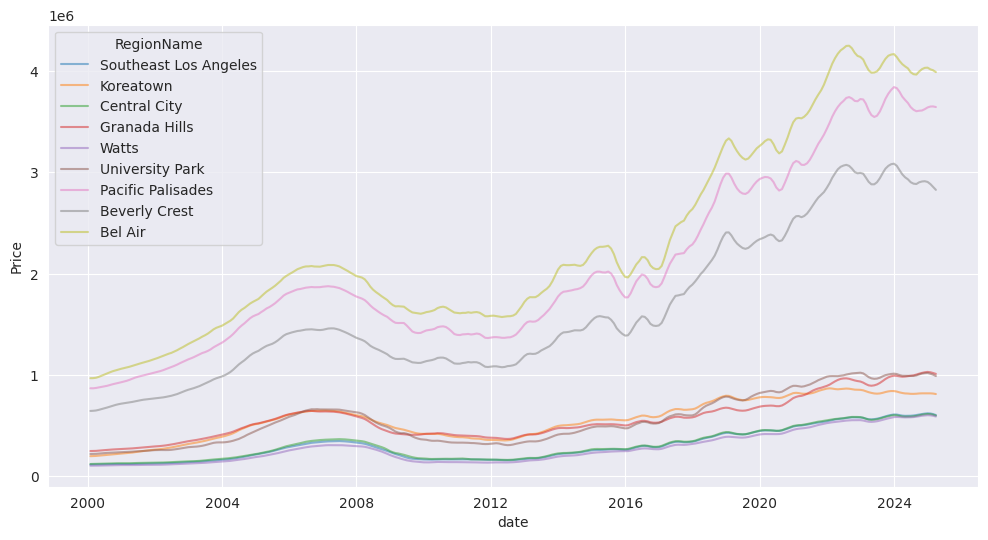

In [117]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=zhvi_df_angeles_long_muestra, x="date", y="Price", hue="RegionName", palette="tab10", alpha=0.5)

## Tratamiento de datos nulos | Imputación por medias condicionales

Para el tratamiento de datos nulos, se opta por el tratamiento por medias condicionales, es decir, se imputan los datos nulos por la media de los datos que no son nulos. Para ello, se agrupan los datos por vecindario y se calcula la media de los datos que no son nulos. Posteriormente, se reemplazan los datos nulos por la media calculada. Este tratamiento se realiza para cada vecindario y para cada mes.

In [118]:
zhvi_df_angeles_long.isnull().sum()/len(zhvi_df_angeles_long)

RegionID     0.00
SizeRank     0.00
RegionName   0.00
date         0.00
Price        0.01
año          0.00
year         0.00
month        0.00
dtype: float64

In [119]:
city_with_null_values = zhvi_df_angeles_long[zhvi_df_angeles_long["Price"].isnull()]["RegionName"].unique()
city_with_null_values

array(['Chinatown', 'Playa Vista'], dtype=object)

In [120]:
zhvi_df_city_null_values = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"].isin([*city_with_null_values])]
zhvi_df_city_null_values

,RegionID,SizeRank,RegionName,date,Price,año,year,month
83,276257,2208,Chinatown,2000-01-31,NaN,2000,2000,1
84,13327,2338,Playa Vista,2000-01-31,NaN,2000,2000,1
182,276257,2208,Chinatown,2000-02-29,NaN,2000,2000,2
183,13327,2338,Playa Vista,2000-02-29,NaN,2000,2000,2
281,276257,2208,Chinatown,2000-03-31,NaN,2000,2000,3
...,...,...,...,...,...,...,...,...
29784,13327,2338,Playa Vista,2025-01-31,"1,382,269.75",2025,2025,1
29882,276257,2208,Chinatown,2025-02-28,"843,262.95",2025,2025,2
29883,13327,2338,Playa Vista,2025-02-28,"1,380,526.49",2025,2025,2
29981,276257,2208,Chinatown,2025-03-31,"830,083.90",2025,2025,3


In [121]:
zhvi_df_city_null_values["Year"] = zhvi_df_city_null_values.loc[:, "date"].dt.year
zhvi_df_city_null_values["Month"] = zhvi_df_city_null_values.loc[:, "date"].dt.month

/tmp/ipykernel_5128/2467845591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zhvi_df_city_null_values["Year"] = zhvi_df_city_null_values.loc[:, "date"].dt.year
/tmp/ipykernel_5128/2467845591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zhvi_df_city_null_values["Month"] = zhvi_df_city_null_values.loc[:, "date"].dt.month


In [122]:
zhvi_df_city_null_values.isnull().sum()/len(zhvi_df_city_null_values)

RegionID     0.00
SizeRank     0.00
RegionName   0.00
date         0.00
Price        0.56
año          0.00
year         0.00
month        0.00
Year         0.00
Month        0.00
dtype: float64

In [123]:
zhvi_df_city_null_values.pivot_table(index="Year", columns="RegionName", values="Price", aggfunc=["count", "mean"])

count                   mean             
RegionName Chinatown Playa Vista  Chinatown  Playa Vista
Year                                                    
2000               0           0        NaN          NaN
2001               0           0        NaN          NaN
2002               0           0        NaN          NaN
2003               0           0        NaN          NaN
2004               0           0        NaN          NaN
2005               0           0        NaN          NaN
2006               0           0        NaN          NaN
2007               0           0        NaN          NaN
2008               0          12        NaN   717,930.56
2009               0          12        NaN   648,563.82
2010               0          12        NaN   629,108.19
2011               0          12        NaN   588,470.29
2012               0          12        NaN   574,318.26
2013               0          12        NaN   666,609.46
2014               0          12        NaN   766,116.35
2015               0          12        NaN   839,635.66
2016               0          12        NaN   915,769.96
2017               0          12        NaN   979,618.31
2018               0          12        NaN 1,113,044.39
2019               0          12        NaN 1,158,868.76
2020              11          12 712,589.99 1,142,573.86
2021              12          12 783,444.18 1,181,657.49
2022              12          12 852,482.80 1,303,183.59
2023              12          12 866,129.35 1,306,765.02
2024              12          12 871,318.02 1,366,481.11
2025               3           3 843,582.50 1,379,152.08

### Estimación de por medias condicionales

A través del análisis realizado a los datos de ZHVI, se ha podido observar que existen ciertos vecindarios que tienen un valor de vivienda nulo. Esto puede ser debido a que no existen datos disponibles para esos vecindarios en el periodo analizado. Por tanto, se ha decidido imputar a través de medias condicionales considerando la cercancia de los vecindarios para realizar la regresión, es decir, para ajustar el modelo no se tomaran todos los vecindarios, sino que se tomaran solo aquellos que se encuentren en un rango menor a 10 kilometros de distancia.

Esto tiene el objetivo de poder aproximar con una mayor exactitud el valor real de la vienda en ese punto  concreto, ya que se espera que los vecindarios cercanos tengan un valor de vivienda similar.

Es por ello, que para los dos vecindarios que tiene valores se ha decidido considerar los siguientes vecindarios para la regresión lineal múltiple, para cada uno de ellos

**Regiones cercanas a Chinatown**

| Barrio             | Ubicación relativa a Chinatown‑LA           | Distancia aprox. (km / mi) |
|--------------------|---------------------------------------------|----------------------------|
| Elysian Park       | Norte                                       | 2.0 km / 1.2 mi            |
| Lincoln Heights    | Noreste (cruzando el río L.A.)              | 2.7 km / 1.6 mi            |
| Echo Park          | Noroeste                                    | 2.7 km / 1.7 mi            |
| Cypress Park       | NNE (valle del río L.A.)                    | 3.4 km / 2.1 mi            |
| Westlake           | Suroeste (MacArthur Park)                   | 4.2 km / 2.6 mi            |
| Boyle Heights      | Sureste (al este del río L.A.)              | 4.4 km / 2.7 mi            |
| Mount Washington   | NNE (colinas de NELA)                       | 4.5 km / 2.8 mi            |

**Regiones cercanas a Playa Vista**

| Barrio         | Ubicación relativa a Playa Vista       | Distancia aprox. (km / mi) |
|----------------|----------------------------------------|----------------------------|
| Del Rey        | Noreste inmediato                      | 1.5 km / 0.9 mi            |
| Westchester    | Sur                                    | 2.5 km / 1.6 mi            |
| Playa del Rey  | Suroeste (costero)                     | 3.1 km / 1.9 mi            |
| Mar Vista      | Norte                                  | 3.5 km / 2.2 mi            |
| Venice         | Noroeste (costero)                     | 4.3 km / 2.7 mi            |
| Palms          | Noreste                                | 5.0 km / 3.1 mi            |
| Sawtelle       | Norte‑noroeste                         | 7.3 km / 4.5 mi            |


### Proceso de estimación Chinatown

In [124]:
barrios_cercamos_chinatown = ["Lincoln Heights", "Elysia Park", "Echo Park", "Boyle Heights", "Cypress Park", "Mount Washington", "Westlake"]

In [125]:
df_barrios_cercamos_chinatown = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"].isin(barrios_cercamos_chinatown)]
df_chinatown = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"] == "Chinatown"]

In [126]:
df_chinatown.describe()

,RegionID,SizeRank,date,Price,año,year,month
count,303.00,303.00,303,62.00,303.00,303.00,303.00
mean,"276,257.00","2,208.00",2012-08-30 04:35:38.613861376,"820,156.93","2,012.13","2,012.13",6.46
min,"276,257.00","2,208.00",2000-01-31 00:00:00,"691,847.98","2,000.00","2,000.00",1.00
25%,"276,257.00","2,208.00",2006-05-15 12:00:00,"775,253.11","2,006.00","2,006.00",3.00
50%,"276,257.00","2,208.00",2012-08-31 00:00:00,"847,133.81","2,012.00","2,012.00",6.00
75%,"276,257.00","2,208.00",2018-12-15 12:00:00,"868,833.50","2,018.00","2,018.00",9.00
max,"276,257.00","2,208.00",2025-03-31 00:00:00,"888,150.90","2,025.00","2,025.00",12.00
std,0.00,0.00,NaN,"61,447.60",7.30,7.30,3.47


In [127]:
df_barrios_cercamos_chinatown.describe()

,RegionID,SizeRank,date,Price,año,year,month
count,"1,818.00","1,818.00",1818,"1,818.00","1,818.00","1,818.00","1,818.00"
mean,"193,187.67",632.67,2012-08-30 04:35:38.613861376,"480,410.62","2,012.13","2,012.13",6.46
min,"113,886.00",72.00,2000-01-31 00:00:00,"129,138.98","2,000.00","2,000.00",1.00
25%,"116,206.00",93.00,2006-04-30 00:00:00,"270,658.90","2,006.00","2,006.00",3.00
50%,"192,438.50",489.00,2012-08-31 00:00:00,"423,823.75","2,012.00","2,012.00",6.00
75%,"268,134.00",850.00,2018-12-31 00:00:00,"639,496.21","2,018.00","2,018.00",9.00
max,"276,023.00","1,803.00",2025-03-31 00:00:00,"1,247,953.92","2,025.00","2,025.00",12.00
std,"77,636.79",589.48,NaN,"259,528.80",7.29,7.29,3.47


In [128]:
df_chinatown["Price"].skew()

np.float64(-0.9191505357653911)

In [129]:
df_barrios_cercamos_chinatown["Price"].skew()

np.float64(0.9130086426636489)

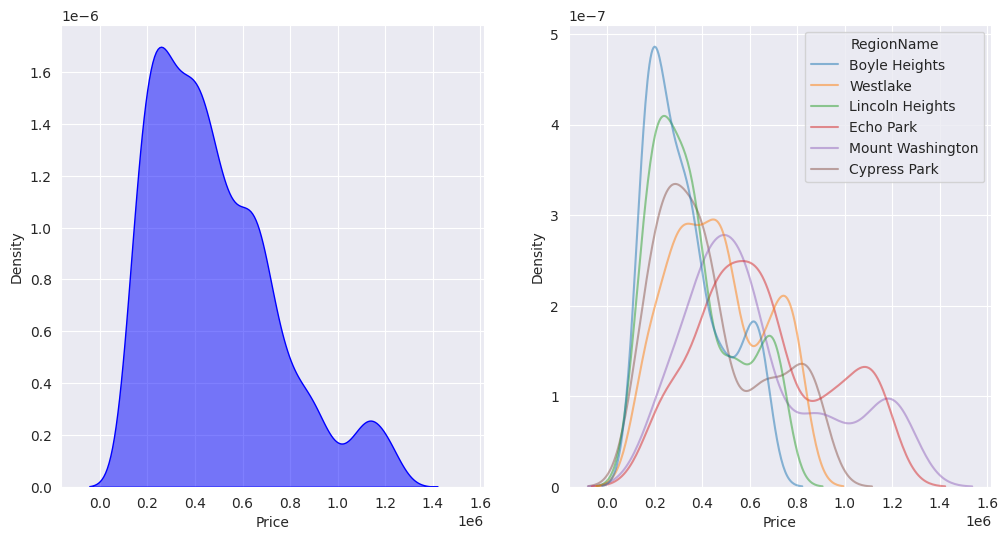

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

sns.kdeplot(data=df_barrios_cercamos_chinatown, x="Price", fill=True, color="blue", alpha=0.5, ax=ax1)
sns.kdeplot(data=df_barrios_cercamos_chinatown, x="Price", fill=False, alpha=0.5, ax=ax2, hue="RegionName")

plt.show()

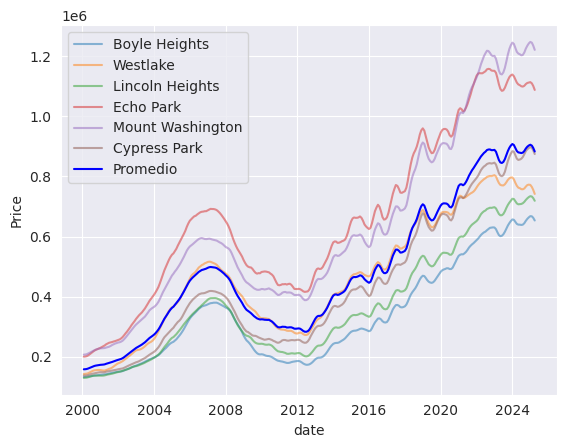

In [131]:
df_groupby_chinatown_mean = df_barrios_cercamos_chinatown.groupby("date").agg({"Price" : "mean"}).reset_index()
df_groupby_chinatown_mean

sns.lineplot(data=df_barrios_cercamos_chinatown, x="date", y="Price", hue="RegionName", palette="tab10", alpha=0.5)
sns.lineplot(data=df_groupby_chinatown_mean, x="date", y="Price", color="blue", label="Promedio")

plt.legend()
plt.show()

In [132]:
#Se obtiene la fecha del primer reporte de precios en el dataframe de Chinatown
fecha_primer_reporte = df_chinatown[df_chinatown["Price"] > 0]["date"].min()

#Se filtra el dataframe de barrios cercanos a Chinatown para obtener solo los datos desde la fecha del primer reporte
df_barrios_cercanos_chinatown_primer_fecha = df_barrios_cercamos_chinatown[df_barrios_cercamos_chinatown["date"] >= fecha_primer_reporte].copy()

df_barrios_cercanos_chinatown_primer_fecha.describe()

,RegionID,SizeRank,date,Price,año,year,month
count,372.00,372.00,372,372.00,372.00,372.00,372.00
mean,"193,187.67",632.67,2022-09-14 22:50:19.354838784,"837,027.68","2,022.18","2,022.18",6.37
min,"113,886.00",72.00,2020-02-29 00:00:00,"490,042.92","2,020.00","2,020.00",1.00
25%,"116,206.00",93.00,2021-05-31 00:00:00,"671,532.60","2,021.00","2,021.00",3.00
50%,"192,438.50",489.00,2022-09-15 00:00:00,"777,402.28","2,022.00","2,022.00",6.00
75%,"268,134.00",850.00,2023-12-31 00:00:00,"1,030,152.96","2,023.00","2,023.00",9.00
max,"276,023.00","1,803.00",2025-03-31 00:00:00,"1,247,953.92","2,025.00","2,025.00",12.00
std,"77,719.97",590.11,NaN,"213,235.85",1.51,1.51,3.47


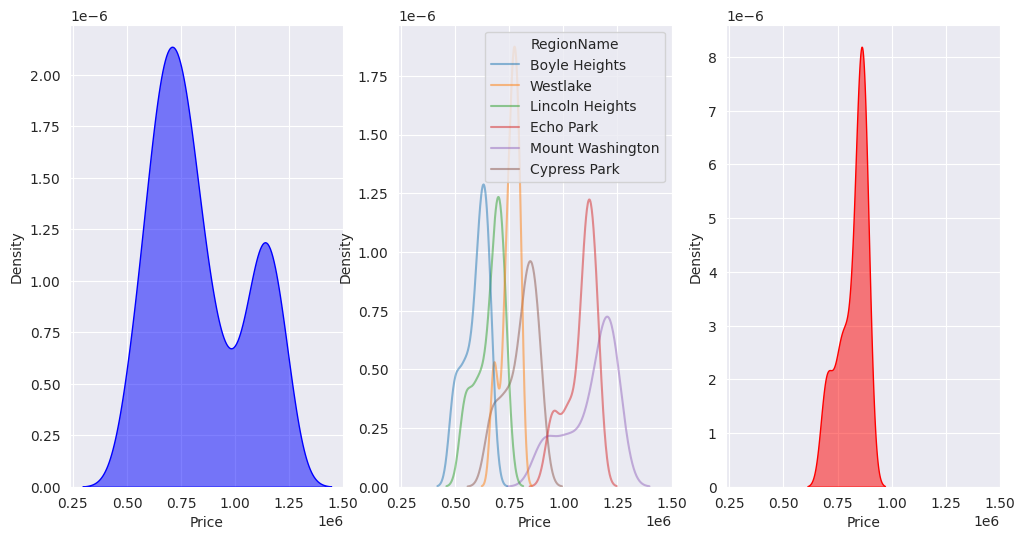

In [133]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharex=True)

sns.kdeplot(data=df_barrios_cercanos_chinatown_primer_fecha, x="Price", fill=True, color="blue", alpha=0.5, ax=ax1)
sns.kdeplot(data=df_barrios_cercanos_chinatown_primer_fecha, x="Price", fill=False, alpha=0.5, ax=ax2, hue="RegionName")

sns.kdeplot(data=df_chinatown, x="Price", fill=True, color="red", alpha=0.5, ax=ax3)

plt.show()

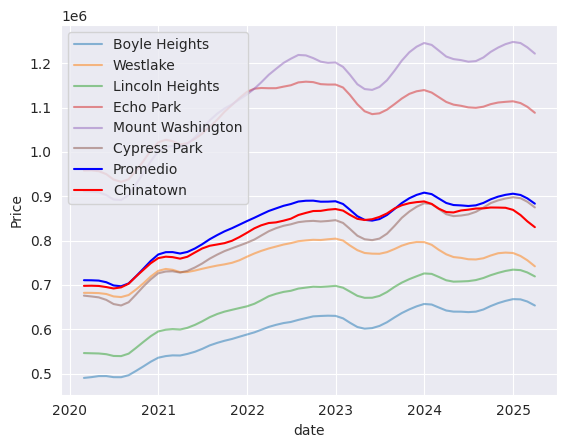

In [134]:
df_groupby_chinatown_mean_primer_fecha = df_groupby_chinatown_mean[df_groupby_chinatown_mean["date"] >= fecha_primer_reporte]

sns.lineplot(data=df_barrios_cercanos_chinatown_primer_fecha, x="date", y="Price", hue="RegionName", palette="tab10", alpha=0.5)

#Proyeccion de la serie con el promedio de los datos
sns.lineplot(data=df_groupby_chinatown_mean_primer_fecha, x="date", y="Price", color="blue", label="Promedio")

#Proyeccion de la serie con datos faltantes
sns.lineplot(data=df_chinatown, x="date", y="Price", color="red", label="Chinatown")

plt.legend()
plt.show()

### Asignación de variables

Dados los resultados obtenidos del análisis de regresión y de las pruebas estadísticas realizadas, así como de la apreciación de la diferenciación entre la media del precio de la región analizar y de el promedio de los precios de las diferentes regiones cercanas a esta, se ha decido optar por imputar los valores de esta región como resultado de un ajuste de las medias de las demás regiones en el tiempo y no como el producto de una regresión. 

En este sentido se asignará el valor promedio de los precios de las regresión circundantes del barrio analizado como estimación de los valores correspondientes a este para los años anteriores.

In [135]:
df_groupby_chinatown_mean

,date,Price
0,2000-01-31,"157,850.25"
1,2000-02-29,"158,135.32"
2,2000-03-31,"158,910.75"
3,2000-04-30,"160,559.07"
4,2000-05-31,"162,752.41"
...,...,...
298,2024-11-30,"903,051.11"
299,2024-12-31,"905,595.47"
300,2025-01-31,"902,706.95"
301,2025-02-28,"895,085.45"


In [136]:
mask = (
    (zhvi_df_angeles_long["RegionName"] == "Chinatown")
    & (zhvi_df_angeles_long["date"] < fecha_primer_reporte)
)

valores_pre_reporte = df_groupby_chinatown_mean.loc[
    df_groupby_chinatown_mean["date"] < fecha_primer_reporte,
    "Price"
].values

zhvi_df_angeles_long.loc[mask, "Price"] = valores_pre_reporte

zhvi_df_angeles_long.loc[mask, ["RegionName", "date", "Price"]]

,RegionName,date,Price
83,Chinatown,2000-01-31,"157,850.25"
182,Chinatown,2000-02-29,"158,135.32"
281,Chinatown,2000-03-31,"158,910.75"
380,Chinatown,2000-04-30,"160,559.07"
479,Chinatown,2000-05-31,"162,752.41"
...,...,...,...
23447,Chinatown,2019-09-30,"673,001.81"
23546,Chinatown,2019-10-31,"683,911.62"
23645,Chinatown,2019-11-30,"693,789.03"
23744,Chinatown,2019-12-31,"703,130.66"


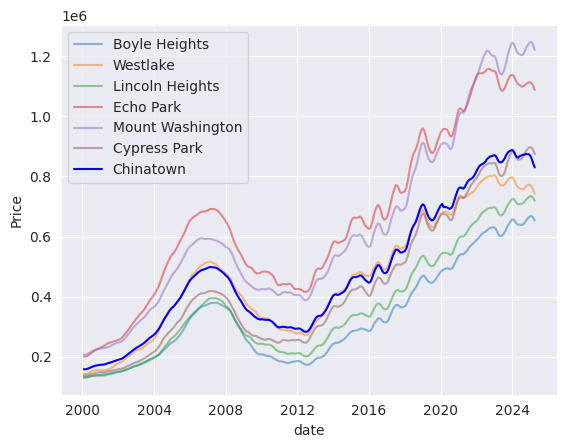

In [137]:
mask = (zhvi_df_angeles_long["RegionName"] == "Chinatown")

sns.lineplot(data=df_barrios_cercamos_chinatown, x="date", y="Price", hue="RegionName", palette="tab10", alpha=0.5)
sns.lineplot(data=zhvi_df_angeles_long.loc[mask,:], x="date", y="Price", color="blue", label="Chinatown")

plt.legend()
plt.show()

### Proceso de estimación Playa Vista

In [138]:
barrios_cercamos_playa_vista = ["Del Rey", "Westchester", "Playa del Rey", "Mar Vista", "Venice", "Palms", "Sawtelle"]

In [139]:
df_barrios_cercamos_playa_vista = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"].isin(barrios_cercamos_playa_vista)]
df_playa_vista = zhvi_df_angeles_long[zhvi_df_angeles_long["RegionName"] == "Playa Vista"]

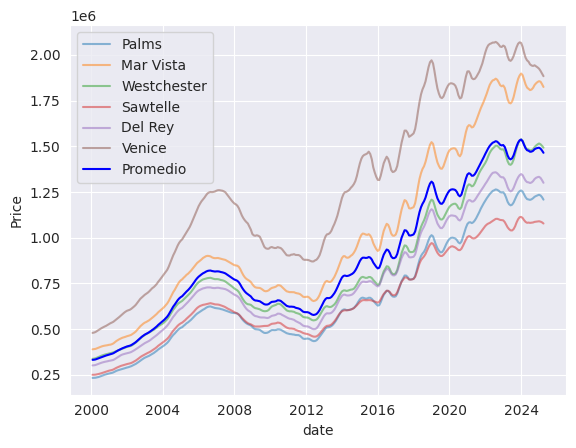

In [140]:
df_groupby_playa_vista_cercanos_mean = df_barrios_cercamos_playa_vista.groupby("date").agg({"Price" : "mean"}).reset_index()

sns.lineplot(data=df_barrios_cercamos_playa_vista, x="date", y="Price", hue="RegionName", palette="tab10", alpha=0.5)
sns.lineplot(data=df_groupby_playa_vista_cercanos_mean, x="date", y="Price", color="blue", label="Promedio")

plt.legend()
plt.show()

In [141]:
#Se obtiene la fecha del primer reporte de precios en el dataframe de playa vista
fecha_primer_reporte = df_playa_vista[df_playa_vista["Price"] > 0]["date"].min()

#Se filtra el dataframe de barrios cercanos a playa vista para obtener solo los datos desde la fecha del primer reporte
df_barrios_cercanos_playa_vista_primer_fecha = df_barrios_cercamos_playa_vista[df_barrios_cercamos_playa_vista["date"] >= fecha_primer_reporte].copy()

df_barrios_cercanos_playa_vista_primer_fecha.describe()

,RegionID,SizeRank,date,Price,año,year,month
count,"1,242.00","1,242.00",1242,"1,242.00","1,242.00","1,242.00","1,242.00"
mean,"130,611.50",344.83,2016-08-30 04:45:13.043478272,"1,009,857.83","2,016.13","2,016.13",6.43
min,"7,877.00",271.00,2008-01-31 00:00:00,"434,411.58","2,008.00","2,008.00",1.00
25%,"21,056.00",280.00,2012-04-30 00:00:00,"657,448.61","2,012.00","2,012.00",3.00
50%,"116,799.00",340.50,2016-08-31 00:00:00,"938,442.34","2,016.00","2,016.00",6.00
75%,"117,954.00",378.00,2020-12-31 00:00:00,"1,259,178.44","2,020.00","2,020.00",9.00
max,"403,184.00",459.00,2025-03-31 00:00:00,"2,070,927.68","2,025.00","2,025.00",12.00
std,"130,375.18",66.47,NaN,"421,932.17",4.98,4.98,3.47


In [144]:
mask = (
    (zhvi_df_angeles_long["RegionName"] == "Playa Vista")
    & (zhvi_df_angeles_long["date"] < fecha_primer_reporte)
)

valores_pre_reporte = df_groupby_playa_vista_cercanos_mean.loc[
    df_groupby_playa_vista_cercanos_mean["date"] < fecha_primer_reporte,
    "Price"
].values

zhvi_df_angeles_long.loc[mask, "Price"] = valores_pre_reporte

zhvi_df_angeles_long.loc[mask, ["RegionName", "date", "Price"]]

,RegionName,date,Price
84,Playa Vista,2000-01-31,"331,933.74"
183,Playa Vista,2000-02-29,"332,708.60"
282,Playa Vista,2000-03-31,"334,259.27"
381,Playa Vista,2000-04-30,"337,334.83"
480,Playa Vista,2000-05-31,"340,800.16"
...,...,...,...
9093,Playa Vista,2007-08-31,"793,424.89"
9192,Playa Vista,2007-09-30,"787,849.14"
9291,Playa Vista,2007-10-31,"781,782.76"
9390,Playa Vista,2007-11-30,"776,430.77"


In [145]:
zhvi_df_angeles_long["Year"] = zhvi_df_angeles_long["date"].dt.year

zhvi_df_angeles_long.loc[
    (zhvi_df_angeles_long["RegionName"] == 'Playa Vista')
    |(zhvi_df_angeles_long["RegionName"] == 'Chinatown')
    ,:].pivot_table(index="Year", columns="RegionName", values="Price", aggfunc=["count", "mean"])

count                   mean             
RegionName Chinatown Playa Vista  Chinatown  Playa Vista
Year                                                    
2000              12          12 165,427.14   345,576.48
2001              12          12 180,349.59   384,269.00
2002              12          12 208,247.60   435,490.93
2003              12          12 251,271.76   506,593.50
2004              12          12 320,555.60   613,819.64
2005              12          12 406,333.16   731,063.24
2006              12          12 480,563.53   812,168.81
2007              12          12 489,637.35   798,057.49
2008              12          12 418,524.26   717,930.56
2009              12          12 339,130.87   648,563.82
2010              12          12 314,042.07   629,108.19
2011              12          12 296,752.80   588,470.29
2012              12          12 295,759.82   574,318.26
2013              12          12 358,441.68   666,609.46
2014              12          12 421,644.98   766,116.35
2015              12          12 461,507.22   839,635.66
2016              12          12 483,143.14   915,769.96
2017              12          12 538,545.92   979,618.31
2018              12          12 640,395.39 1,113,044.39
2019              12          12 676,399.49 1,158,868.76
2020              12          12 712,259.36 1,142,573.86
2021              12          12 783,444.18 1,181,657.49
2022              12          12 852,482.80 1,303,183.59
2023              12          12 866,129.35 1,306,765.02
2024              12          12 871,318.02 1,366,481.11
2025               3           3 843,582.50 1,379,152.08

In [ ]:
zhvi_df_angeles_long.to_csv("./resources/Neighborhood_zhvi_clean.csv", index=False)